# Load dataset

In [1]:
import sys
from pathlib import Path

# Add project root (MLP-FROM-SCRATCH) to sys.path
root_path = Path.cwd().parent
sys.path.insert(0, str(root_path))

# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from core import *  

# Define target function

In [2]:
# Define target function 
def target_fn(x):
    """Complex polynomial function: (0.3x-1)(x²-2)²"""
    return (0.3 * x - 1) * (x**2 - 2)**2 

# Generate synthetic regression data with noise
np.random.seed(42)  # For reproducibility
X = np.linspace(-3, 4, 200).reshape(-1, 1)  # Input features (-3 to 4)
y_true = target_fn(X).ravel()  # True function values
noise = np.random.normal(0, 2.0, size=y_true.shape)  # Gaussian noise
y_noisy = y_true + noise  # Noisy observations

# Split data into training and test sets (80/20 split)
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_noisy, test_size=0.2, random_state=42)

# Define neural network architecture for regression:

In [3]:
model = NeuralNetwork()
model.add_layer(Linear(input_size=1, output_size=64, init_type='he'))
model.add_layer(ReLULayer())
model.add_layer(Linear(64, 64, init_type='he'))
model.add_layer(ReLULayer())
model.add_layer(Linear(64, 1))  # Final linear layer for regression output

# Use Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=1e-3)

# Training configuration

In [4]:
# Train loop 
epochs = 500  # Total training iterations
batch_size = 32  # Mini-batch size
train_losses = []  # To track loss history

# Training loop
for epoch in range(1, epochs+1):
    epoch_loss = 0
    batches = 0

    # Process data in mini-batches
    for xb, yb in batch_iterator(X_train, y_train.reshape(-1, 1), 
                          batch_size=batch_size, shuffle=True):
        # Forward pass: compute predictions
        preds = model.forward(xb)
        # Calculate mean squared error loss
        loss = mse_loss(preds, yb)
        epoch_loss += loss

        # Backward pass: compute gradients
        grad = mse_loss_derivative(preds, yb)
        model.backward(grad)

        # Update weights using Adam optimizer
        model.update_params(optimizer)
        model.zero_grad()  # Reset gradients for next iteration

        batches += 1

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / batches
    train_losses.append(avg_loss)

    # Print training progress every 50 epochs
    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}")

Epoch 1/500 - Loss: 415.9200
Epoch 50/500 - Loss: 167.7466
Epoch 100/500 - Loss: 120.5888
Epoch 150/500 - Loss: 59.4316
Epoch 200/500 - Loss: 26.9943
Epoch 250/500 - Loss: 13.8890
Epoch 300/500 - Loss: 9.5862
Epoch 350/500 - Loss: 7.4370
Epoch 400/500 - Loss: 6.0328
Epoch 450/500 - Loss: 5.1906
Epoch 500/500 - Loss: 4.7987


# Model evaluation on training and test sets

In [5]:
# Evaluate 
model.eval()  # Set model to evaluation mode
y_pred_train = model.forward(X_train).ravel()  # Training set predictions
y_pred_test = model.forward(X_test).ravel()  # Test set predictions

# Calculate mean squared error metrics
mse_train = np.mean((y_pred_train - y_train)**2)
mse_test = np.mean((y_pred_test - y_test)**2)
print(f"Train MSE: {mse_train:.4f}, Test MSE: {mse_test:.4f}")

Train MSE: 4.6188, Test MSE: 4.0817


# Plot 

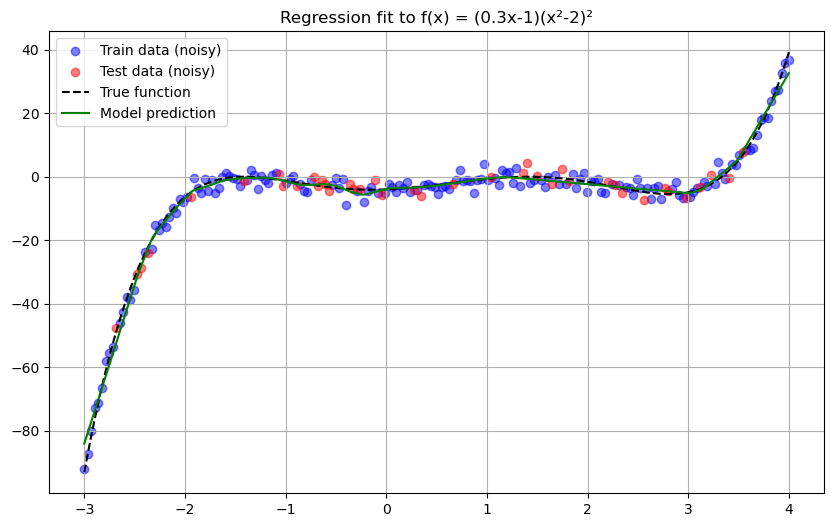

In [7]:
# Visualization of results
x_dense = np.linspace(-3, 4, 400).reshape(-1, 1)  # Dense grid for plotting
y_dense_true = target_fn(x_dense)  # True function values
y_dense_pred = model.forward(x_dense).ravel()  # Model predictions

plt.figure(figsize=(10,6))
# Plot training data points
plt.scatter(X_train, y_train, color='blue', alpha=0.5, label='Train data (noisy)')
# Plot test data points
plt.scatter(X_test, y_test, color='red', alpha=0.5, label='Test data (noisy)')
# Plot true function curve
plt.plot(x_dense, y_dense_true, 'k--', label='True function')
# Plot model predictions
plt.plot(x_dense, y_dense_pred, 'g', label='Model prediction')
plt.title('Regression fit to f(x) = (0.3x-1)(x²-2)²')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Save model
filepath = root_path / 'models' / 'regression_model.pkl'
save_checkpoint(model, optimizer, filepath)